In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, make_scorer,
    roc_auc_score, roc_curve
)
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_sample_weight
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


# Introduction
Credit card fraud is a major challenge in the financial industry, with fraudulent transactions making up a tiny fraction of all activity. Detecting these rare events is crucial for protecting customers and reducing financial losses. As can be seen in the following EDA the extreme class imbalance (fraud cases <0.2% of the dataset) makes this a particularly difficult machine learning problem.

In this notebook, we apply a Support Vector Machine (SVM) classifier to a Kaggle credit card fraud detection dataset.

# Exploratory Data Analysis

## Dataset Load

In [13]:
pd.set_option('display.max_columns', None)
df=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Target Variable Analysis

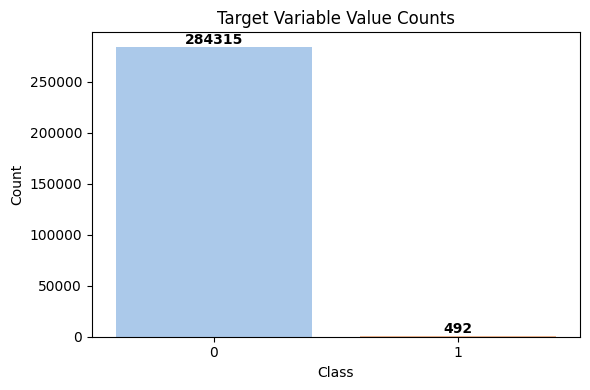

In [14]:
class_counts = df['Class'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Target Variable Value Counts')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + max(class_counts.values)*0.01, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## Feature Correlation

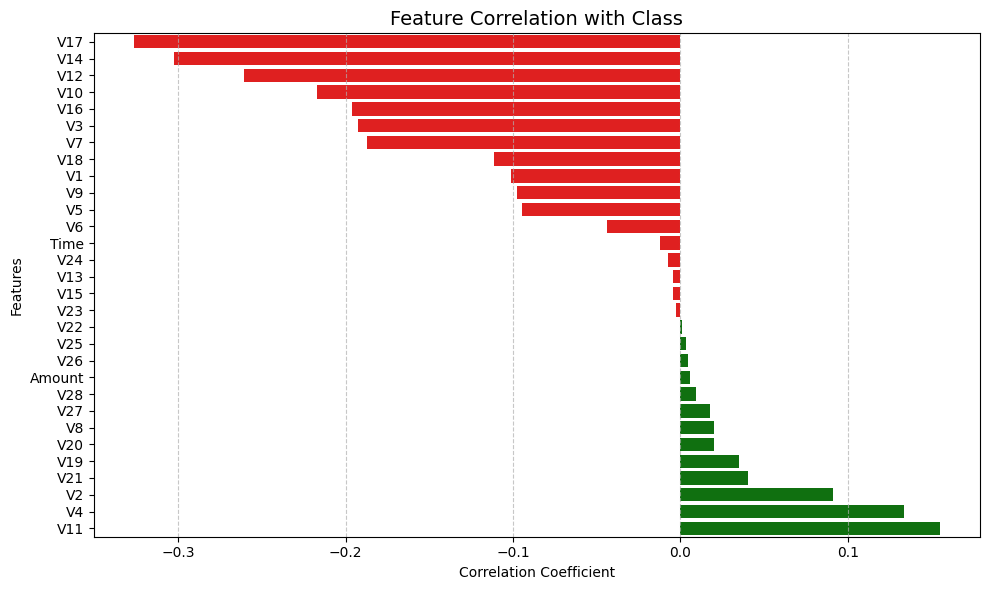

In [15]:
sorted_corr = df.corr()['Class'].drop('Class').sort_values()

colors = ['red' if val < 0 else 'green' for val in sorted_corr]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette=colors)
plt.title("Feature Correlation with Class", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The feature correlation heatmap shows that most features in the dataset are weakly correlated with each other, which is expected since the data has been PCA-transformed. The low correlations suggest minimal redundancy among features, making them suitable for use in models like SVM.

## Data Quality Check

In [16]:
#Null values
round(100 * (df.isnull().sum()/len(df)),2)

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

In [17]:
#Duplicates
df = df.drop_duplicates()
df.duplicated().sum()


0

# Preprocessing

In [18]:
data =df.copy()
X = data.drop(columns=['Time','Class']) #we ignore time
y = data['Class']

#Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalize samples with L2 norm
X_normalized = normalize(X_scaled, norm='l2')

# Train/Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scikit learn SVM

In [20]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(class_weight="balanced", random_state=42, max_iter=1000))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__loss": ["squared_hinge"],
    "clf__dual": [False]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(f1_score),   # optimize for fraud detection balance
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score (F1):", grid.best_score_)

best_model = grid.best_estimator_



Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'clf__C': 0.01, 'clf__dual': False, 'clf__loss': 'squared_hinge'}
Best CV Score (F1): 0.13706938374502672


# ROC analysis

SVM ROC-AUC score: 0.974


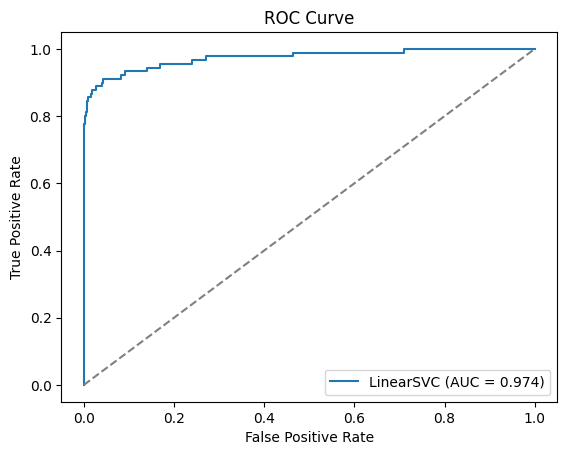

In [21]:
y_scores = best_model.decision_function(X_test)
roc_auc_svm = roc_auc_score(y_test, y_scores)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f"LinearSVC (AUC = {roc_auc_svm:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

The high ROC-AUC score indicates that fraudulent and non-fraudulent transactions are effectively separable with a linear SVM. This suggests that more complex kernel methods are not necessary, as a linear decision boundary in the current feature space provides strong performance. Given the dataset’s PCA-transformed features, the linear hyperplane is sufficient to capture the underlying patterns for fraud detection.1. 